# Business Understanding

## Introduction
Traffic accidents are a critical public safety issue, causing injuries, fatalities and significant economic losses. Stakeholders such as traffic authorities and emergency services often face challenges in predicting and mitigating injury severity in crashes. Understanding the factors influencing injury outcomes can inform better policies, resource allocation and public safety to reduce injury severity and save lives.

## Use Cases
- Use the model to identify high-risk conditions (eg. weather, lighting, etc.) and implement measures like improved signage, speed limits or road design to reduce injury severity in traffic accidents.
- Predict the severity of injuries based on crash conditions, enabling emergency services to prioritize resources and respond more effectively to severe accidents. 

## Value Proposition
This project aims to develop a classification model that predicts injury severity in traffic crashes. By identifying key high-risk contributing to severe injuries, stakeholders can implement proactive measures to:
    - Reduce injury severity in traffic accidents through ad-hoc interventions
    - Enhance decision-making and resource allocation for emergency services
    - Improve public safety and save lives

# Business Objective
- The task is to predict the severity of injuries based on the given features:
    - Environment: The environment in which the accident occurred.
        - POSTED_SPEED_LIMIT: The posted speed limit.
        - WEAHTER_CONDITION: The weather condition.
        - LIGHTING_CONDITION: The lighting condition.
        - ROADWAY_SURFACE_COND: The roadway surface condition.
        - ROAD_DEFECT: Whether or not the road was defective.
        - TRAFFICWAY_TYPE: The type of trafficway.
        - TRAFFIC_CONTROL_DEVICE: The traffic control device present at the location of the accident.
    - Crash Dynamics: The dynamics of the crash.
        - FIRST_CRASH_TYPE: The type of the first crash.
        - TRAFFICWAY_TYPE: The type of trafficway.
        - ALIGNMENT: The alignment of the road.
        - LANE_CNT: The number of through lanes in either direction.
        - CRASH_HOUR: The hour of the crash.
        - CRASH_DAY_OF_WEEK: The day of the week of the crash.
        - CRASH_MONTH: The month of the crash.
    - Human Factors:
        - PRIM_CONTRIBUTORY_CAUSE: The primary contributory cause of the accident.
        - SEC_CONTRIBUTORY_CAUSE: The secondary contributory cause of the accident.
        - HIT_AND_RUN_I: Whether or not the crash involved a hit and run.
        - NOT_RIGHT_OF_WAY_I: Whether or not the crash involved a violation of the right of way.
        - WORK_ZONE_I: Whether or not the crash occurred in a work zone.
    - Location Factors:
        - LATITUDE: The latitude of the location of the crash.
        - LONGITUDE: The longitude of the location of the crash.
        - BEAT_OF_OCCURRENCE: The police beat of occurrence.
    - Target:
        - MOST_SEVERE_INJURY: Multi-class classification target (eg. FATAL, INCAPACITATING INJURY, NONINCAPACITATING INJURY, REPORTED, NO INJURY).


# Data Understanding

## Introduction
The dataset contains information about traffic accidents in Chicago. Stakeholders need reliable data-driven insights to mitigate injury severity and optimize their strategies. The dataset in this project is directly related to the task of predicting injury severity in traffic accidents.

## Data Description
- The dataset includes detailed records of traffic accidents covering various features such as environment, crash dynamics, human factors, location factors and target variable MOST_SEVERE_INJURY.

## Data Quality
- The dataset is very large with over 400,000 records and 49 features, providing a rich source of information for analysis.
- The dataset comes from the City of Chicago's [open data portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if) and is updated daily making it a reliable source of information for stakeholders.

## Data Relevance
- Use data on crash conditions (eg. weather) to identify high-risk conditions take proative measures.
- Predict injury severity to prioritize emergency services and allocate resources more effectively. 

## Conclusion
The dataset is robust, relevant and continually updated, making it an indispensable resource for the task of predicting injury severity in traffic accidents. 

# Data Preparation

## Assembly
- The source data is comprised of three CSV files:
    - [Crash Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data)
    - [Driver/Passenger Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data)
    - [Vehicles Data](https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3/about_data)
- The data will be assembled into a single dataset by joining the three tables on the common key CRASH_RECORD_ID.

## Cleaning
- Irrelevant columns that do not contribute to the task will be dropped.
- Missing values that will be imputed or dropped.

## Transformation
- Categorical features will be encoded using one-hot encoding.
- Numerical features will be scaled using standard scaling.

## Splitting
- The dataset will be split into training and testing sets using a standard 80/20 split.

## Import Libraries

In [6]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

## Load Data

In [7]:
# load data
data = pd.read_csv('./data/Traffic_Crashes_-_Crashes_20250122.csv')
data_vehicles = pd.read_csv('./data/Traffic_Crashes_-_Vehicles_20250122.csv')
data_people= pd.read_csv('./data/Traffic_Crashes_-_People_20250122.csv')

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_8254/1440556926.py:3: DtypeWarning: Columns (18,20,22,23,39,40,41,42,43,47,48,49,50,51,52,53,54,55,56,57,58,59,60,68,69,70) have mixed types. Specify dtype option on import or set low_memory=False.
  data_vehicles = pd.read_csv('./data/Traffic_Crashes_-_Vehicles_20250122.csv')
/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_8254/1440556926.py:4: DtypeWarning: Columns (19,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data_people= pd.read_csv('./data/Traffic_Crashes_-_People_20250122.csv')


In [8]:
# merge data
data = data.merge(data_vehicles, on='CRASH_RECORD_ID')
data = data.merge(data_people, on='CRASH_RECORD_ID')

In [9]:
# assign target variable and drop it from the features
target = data['MOST_SEVERE_INJURY']
data.drop('MOST_SEVERE_INJURY', axis=1, inplace=True)

# combine y and y_enc into a DataFrame
label_encoder = LabelEncoder()
target_enc = label_encoder.fit_transform(target)
y_data = pd.DataFrame({'Original_Target': target, 'Encoded_Target': target_enc})

# save to CSV
y_data.to_csv('./checkpoint/target.csv', index=False)

In [10]:
# Load the CSV file
y_data = pd.read_csv('./checkpoint/target.csv')

# Access the columns
y = y_data['Original_Target']  # Original target values
y_enc = y_data['Encoded_Target']  # Encoded target values

# If needed, convert y_enc back to integers (it might be loaded as floats)
y_enc = y_enc.astype(int)


## Intial Clean Up
- Drop features unlikely to influence injury severity.
    - ids
    - location
    - date/time
    - miscellaneous
    - vehicle details
    - hazmat details
    - commerical vehicle details

In [11]:
categorical_drop = [
    # IDs
    'CRASH_RECORD_ID', 'PERSON_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 
    'UN_NO', 'EMS_RUN_NO', 'IDOT_PERMIT_NO', 'UNIT_NO',

    # Dates
    'DATE_POLICE_NOTIFIED', 'CRASH_DATE_EST_I', 'CRASH_DATE_x', 
    'CRASH_DATE_y', 'CRASH_DATE',

    # Geographic
    'CITY', 'STATE', 'ZIPCODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 
    'STREET_NAME', 'STREET_DIRECTION', 'CARRIER_STATE', 'CARRIER_CITY', 
    'STREET_NO', 'BEAT_OF_OCCURRENCE', 'TRAVEL_DIRECTION',

    # Miscellaneous
    'TOWED_BY', 'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 
    'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 
    'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 
    'AREA_99_I', 'WORK_ZONE_TYPE', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 
    'DOORING_I', 'WIDE_LOAD_I', 'REPORT_TYPE', 'CRASH_TYPE',

    # Vehicle
    'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 
    'TRAILER1_WIDTH', 'TRAILER2_WIDTH',

    # Hazardous Materials
    'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'HAZMAT_PRESENT_I', 
    'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 
    'HAZMAT_OUT_OF_SERVICE_I',

    # Commercial Vehicle
    'COMMERCIAL_SRC', 'CARGO_BODY_TYPE', 'VEHICLE_CONFIG', 'GVWR', 
    'CARRIER_NAME', 'MCS_VIO_CAUSE_CRASH_I', 'MCS_REPORT_I', 
    'MCS_REPORT_NO', 'MCS_OUT_OF_SERVICE_I',

    # High/Inf VIF
    'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 
    'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 
    'CRASH_UNIT_ID', 'VEHICLE_ID_x', 'VEHICLE_ID_y',

    # Related to Target
    'INJURY_CLASSIFICATION', 'INJURIES_NO_INDICATION', 'INJURIES_UNKNOWN',

    # Potential Drops
    'VEHICLE_USE', 'BAC_RESULT', 'DRIVERS_LICENSE_STATE', 
    # 'DRIVER_ACTION', 
    # 'PERSON_TYPE', 
    # 'DEVICE_CONDITION', 'TRAFFIC_CONTROL_DEVICE',

    # Additional Drops
    'CMRC_VEH_I', 'TRAVEL_DIRECTION', 'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 
    'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'LOAD_TYPE', 'HAZMAT_CLASS', 
    'SEAT_NO', 'DRIVERS_LICENSE_CLASS', 'HOSPITAL', 'EMS_AGENCY', 
    'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'PEDPEDAL_LOCATION', 
    'BAC_RESULT VALUE', 'CELL_PHONE_USE', 'CMV_ID',
    'TOWED_I', 'FIRE_I'
]

# Drop columns
data.drop(columns=categorical_drop, errors='ignore', inplace=True)

## Data Preparation

### Remove Features with High Rate of Missing Values
- Drop features with high rate of missing values.

In [12]:
# calculate null percentages
null_percentage = data.isnull().mean() * 100

# drop columns with more than 50% missing values
columns_to_drop = null_percentage[null_percentage > 50].index
data = data.drop(columns=columns_to_drop)

### Impute Missing Values
- Median imputation for numerical features.
- Mode imputation for categorical features.

In [13]:
# fill categorical columns with mode
for column in data.select_dtypes(include='object').columns:
    mode_value = data[column].mode()[0]
    data[column] = data[column].fillna(mode_value)

# fill numerical columns with median
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    median_value = data[column].median()
    data[column] = data[column].fillna(median_value)

In [14]:
# checkpoint data
data.to_csv('./checkpoint/data_pre_feat_eng.csv', index=False)

In [15]:
# load data
data = pd.read_csv('./checkpoint/data_pre_feat_eng.csv')

### Grouping Rare Feature Values

In [16]:
# simplify all categorical features by grouping rare categories into a single category by proportion
def simplify_all_categorical_features(df, rare_threshold=0.01, new_category='OTHER'):
    for column in df.select_dtypes(include='object').columns:
        total = len(df)
        value_counts = df[column].value_counts()
        rare_categories = value_counts[value_counts / total < rare_threshold].index
        df[column] = df[column].replace(rare_categories, new_category)
    return df

data = simplify_all_categorical_features(data, rare_threshold=0.01)

### Feature Engineering

In [17]:
# bin the age of driver
data['AGE'] = pd.cut(
    data['AGE'],
    bins = [0, 18, 35, 50, 65, 100],
    labels = ['Child', 'Young Adult', 'Adult', 'Middle-Aged', 'Senior']
)

# bin the number of occupants
data['OCCUPANT_CNT'] = pd.cut(
    data['OCCUPANT_CNT'],
    bins=[-1, 1, 3, 5, 10, 100],
    labels=['None', 'Single', 'Small Group', 'Medium Group', 'Large Group']
)

# bin the crash hour into 4 intervals
data['CRASH_HOUR_BINNED'] = pd.cut(
    data['CRASH_HOUR'],
    bins=[-1, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening']
)

# bin the crash day into 2 intervals
# data['CRASH_DAY_BINARY'] = data['CRASH_DAY_OF_WEEK'].replace({
#     6: 'Weekend', 7: 'Weekend',
#     1: 'Weekday', 2: 'Weekday', 3: 'Weekday', 4: 'Weekday', 5: 'Weekday'
# })
# data = data.drop(columns='CRASH_DAY_OF_WEEK', errors='ignore')

# bin the crash month into 4 intervals
# data['CRASH_MONTH_SEASON'] = data['CRASH_MONTH'].replace({
#     12: 'Winter', 1: 'Winter', 2: 'Winter',
#     3: 'Spring', 4: 'Spring', 5: 'Spring',
#     6: 'Summer', 7: 'Summer', 8: 'Summer',
#     9: 'Fall', 10: 'Fall', 11: 'Fall'
# })
# data = data.drop(columns='CRASH_MONTH', errors='ignore')

# simplify LIGHTING_CONDITION
data['LIGHTING_CONDITION'] = data['LIGHTING_CONDITION'].replace({'DUSK': 'LOW LIGHT', 'DAWN': 'LOW LIGHT'})
data['Daylight'] = data['LIGHTING_CONDITION'].apply(lambda x: 'Daylight' if x == 'DAYLIGHT' else 'Other')

# simplify WEATHER_CONDITION
data['Adverse_Weather'] = data['WEATHER_CONDITION'].apply(lambda x: 'Adverse' if x != 'CLEAR' else 'Clear')

# simplify TRAFFICWAY_TYPE
data['Divided_Trafficway'] = data['TRAFFICWAY_TYPE'].apply(
    lambda x: 'Divided' if 'DIVIDED' in x.upper() else 'Not Divided'
)

# simplify ROADWAY_SURFACE_COND
data['Non_Dry_Surface'] = data['ROADWAY_SURFACE_COND'].apply(lambda x: 'Non-Dry' if x != 'DRY' else 'Dry')

# PRIM_CONTRIBUTORY_CAUSE / SEC_CONTRIBUTORY_CAUSE
def group_contributory_causes(value):
    if 'DISTRACTION' in value.upper():
        return 'Distraction'
    elif 'DRIVING' in value.upper() or 'DRIVER' in value.upper():
        return 'Driver Error'
    elif 'WEATHER' in value.upper():
        return 'Weather'
    elif 'SPEED' in value.upper():
        return 'Speeding'
    else:
        return 'Other'

data['PRIM_CAUSE_GROUP'] = data['PRIM_CONTRIBUTORY_CAUSE'].apply(group_contributory_causes)
data['SEC_CAUSE_GROUP'] = data['SEC_CONTRIBUTORY_CAUSE'].apply(group_contributory_causes)

# simplify contact point to FRONT, SIDE, REAR, OTHER
data['Contact_Broad'] = data['FIRST_CONTACT_POINT'].apply(
    lambda x: 'Front' if 'FRONT' in x.upper() else (
        'Side' if 'SIDE' in x.upper() else (
            'Rear' if 'REAR' in x.upper() else 'Other'
        )
    )
)

# bin speed limits into ranges
data['SPEED_LIMIT_BINNED'] = pd.cut(
    data['POSTED_SPEED_LIMIT'].astype(float, errors='ignore'),
    bins=[-1, 10, 25, 40, 60, 100],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# bin lane counts into ranges
# data['LANE_CNT_BINNED'] = pd.cut(
#     data['LANE_CNT'].astype(float, errors='ignore'),
#     bins=[-1, 1, 3, 5, 8, 100],
#     labels=['Single', 'Few', 'Moderate', 'Many', 'Very Many']
# )

# simplify vehicle types
data['VEHICLE_TYPE'] = data['VEHICLE_TYPE'].replace({
    'TRUCK - SINGLE UNIT': 'Truck',
    'TRACTOR W/ SEMI-TRAILER': 'Truck',
    'TRACTOR W/O SEMI-TRAILER': 'Truck',
    'SINGLE UNIT TRUCK WITH TRAILER': 'Truck',
    'OTHER VEHICLE WITH TRAILER': 'Truck',
    'BUS OVER 15 PASS.': 'Bus',
    'BUS UP TO 15 PASS.': 'Bus',
    'MOTORCYCLE (OVER 150CC)': 'Motorcycle',
    '3-WHEELED MOTORCYCLE (2 REAR WHEELS)': 'Motorcycle',
    'AUTOCYCLE': 'Motorcycle',
    'ALL-TERRAIN VEHICLE (ATV)': 'Motorcycle'
})

# group physical conditions
data['PHYSICAL_CONDITION_GROUP'] = data['PHYSICAL_CONDITION'].replace({
    'IMPAIRED - ALCOHOL': 'Impaired',
    'IMPAIRED - DRUGS': 'Impaired',
    'IMPAIRED - ALCOHOL AND DRUGS': 'Impaired',
    'MEDICATED': 'Impaired',
    'EMOTIONAL': 'Other',
    'FATIGUED/ASLEEP': 'Other',
    'ILLNESS/FAINTED': 'Other',
    'HAD BEEN DRINKING': 'Impaired',
    'NORMAL': 'Normal',
    'UNKNOWN': 'Unknown'
})

In [18]:
# checkpoint
data.to_csv('./checkpoint/data_post_feat_eng.csv', index=False)

In [19]:
# load data
data = pd.read_csv('./checkpoint/data_post_feat_eng.csv')

## Data Preprocessing & Feature Selection

### Significance Testing
- Pearson correlation for numerical features.
- Cramer's V for categorical features.

In [23]:
# Separate numeric and categorical features
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Temporarily add the target variable back to the dataset for correlation
data_with_target = data.copy()
data_with_target['target'] = y_enc


#### Pearson Correlation

In [24]:

# Compute correlation for numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_corr = data_with_target[numeric_features + ['target']].corr(method='pearson')['target']

# Display correlations sorted by absolute value
print("Numeric Feature Correlations:")
print(numeric_corr.abs().sort_values(ascending=False))

Numeric Feature Correlations:
target                1.000000
NUM_UNITS             0.088050
POSTED_SPEED_LIMIT    0.050437
CRASH_MONTH           0.008904
CRASH_HOUR            0.004627
CRASH_DAY_OF_WEEK     0.003755
VEHICLE_YEAR          0.002478
Name: target, dtype: float64


In [26]:
# checkpoint results
numeric_corr.to_csv('./checkpoint/numeric_corr.csv', index=True)

#### Spearman Correlation

In [28]:
# Add the encoded target variable to the dataset temporarily
data_with_target = data.copy()
data_with_target['target'] = y_enc

# Compute Spearman correlation for numeric features
spearman_corr = data_with_target[numeric_features + ['target']].corr(method='spearman')['target']

# Drop the target itself from the results
spearman_corr = spearman_corr.drop('target')

# Display correlations sorted by absolute value
print("Spearman Correlation with Target:")
print(spearman_corr.abs().sort_values(ascending=False))

Spearman Correlation with Target:
NUM_UNITS             0.115515
POSTED_SPEED_LIMIT    0.051704
CRASH_MONTH           0.009250
CRASH_HOUR            0.008639
CRASH_DAY_OF_WEEK     0.004642
VEHICLE_YEAR          0.003614
Name: target, dtype: float64


In [29]:
from scipy.stats import spearmanr

significant_features = {}
for feature in numeric_features:
    # Calculate Spearman correlation and p-value
    corr, p_value = spearmanr(data_with_target[feature], y_enc)
    significant_features[feature] = (corr, p_value)

# Filter features with p-value < 0.05
significant_features = {k: v for k, v in significant_features.items() if v[1] < 0.05}

# Display significant features
print("Significant Features (Spearman Correlation):")
for feature, (corr, p_value) in significant_features.items():
    print(f"{feature}: Correlation={corr:.4f}, P-value={p_value:.4e}")


Significant Features (Spearman Correlation):
POSTED_SPEED_LIMIT: Correlation=0.0517, P-value=0.0000e+00
NUM_UNITS: Correlation=0.1155, P-value=0.0000e+00
CRASH_HOUR: Correlation=0.0086, P-value=3.6171e-70
CRASH_DAY_OF_WEEK: Correlation=-0.0046, P-value=1.8159e-21
CRASH_MONTH: Correlation=0.0093, P-value=3.5774e-80
VEHICLE_YEAR: Correlation=-0.0036, P-value=1.2915e-13


#### Cramer's V

In [25]:
from scipy.stats import chi2_contingency


data_with_target = data.copy()
# note the y variable is unencoded
data_with_target['target'] = y

# calculate Cramers V for categorical features
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Compute correlation for categorical features
categorical_corr = pd.Series(index=categorical_features, dtype='float64')
for feature in categorical_features:
    categorical_corr[feature] = cramers_v(data_with_target[feature], data_with_target['target'])
    
# Display correlations sorted by absolute value
print("Categorical Feature Correlations:")
print(categorical_corr.abs().sort_values(ascending=False))

Categorical Feature Correlations:
FIRST_CRASH_TYPE            0.202954
PERSON_TYPE                 0.156591
AIRBAG_DEPLOYED             0.148547
UNIT_TYPE                   0.142992
PRIM_CONTRIBUTORY_CAUSE     0.117017
DAMAGE                      0.107906
PHYSICAL_CONDITION          0.098106
PHYSICAL_CONDITION_GROUP    0.098106
FIRST_CONTACT_POINT         0.085634
TRAFFICWAY_TYPE             0.082138
SAFETY_EQUIPMENT            0.081642
MANEUVER                    0.074277
DRIVER_ACTION               0.071239
DEVICE_CONDITION            0.068246
EJECTION                    0.067111
Contact_Broad               0.063022
TRAFFIC_CONTROL_DEVICE      0.061908
SEX                         0.060989
SEC_CONTRIBUTORY_CAUSE      0.058395
DRIVER_VISION               0.051833
LIGHTING_CONDITION          0.045956
Daylight                    0.045114
AGE                         0.042273
CRASH_HOUR_BINNED           0.042094
PRIM_CAUSE_GROUP            0.039984
ROADWAY_SURFACE_COND        0.037407
SPEE

In [27]:
# checkpoint results
categorical_corr.to_csv('./checkpoint/categorical_corr.csv', index=True)

### Significance Testing
- Perform chi-squared test for categorical features.
- Perform ANOVA test for numerical features.
- Perform Variance Inflation Factor (VIF) to check for multicollinearity.

### Chi-Squared Test
- Test the independence between categorical features and the target variable.
- Drop features with p-value > 0.05.

In [293]:
# Chi-Square transformer
class ChiSquareTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.selected_indices = None
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

    def fit(self, X, y):
        X_encoded = self.encoder.fit_transform(X)
        chi2_scores, p_values = chi2(X_encoded, y)
        self.selected_indices = np.where(p_values < self.threshold)[0]
        return self

    def transform(self, X):
        X_encoded = self.encoder.transform(X)
        return X_encoded[:, self.selected_indices]


### ANOVA Test
- Test the significance of numerical features on the target variable.
- Drop features with p-value > 0.05.

In [294]:
# ANOVA transformer
class ANOVATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.selected_indices = None
        self.scaler = StandardScaler()

    def fit(self, X, y):
        X_scaled = self.scaler.fit_transform(X)
        f_scores, p_values = f_classif(X_scaled, y)
        self.selected_indices = np.where(p_values < self.threshold)[0]
        return self

    def transform(self, X):
        X_scaled = self.scaler.transform(X)
        return X_scaled[:, self.selected_indices]

### Variance Inflation Factor (VIF)

In [295]:
# custom VIF transformer
class VIFTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=10.0):
        self.threshold = threshold
        self.features_to_keep = None

    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        self.features_to_keep = X.columns.tolist()

        while True:
            vif_data = pd.DataFrame({
                'Feature': self.features_to_keep,
                'VIF': [variance_inflation_factor(X[self.features_to_keep].values, i) for i in range(len(self.features_to_keep))]
            })
            max_vif = vif_data['VIF'].max()
            if max_vif > self.threshold:
                feature_to_remove = vif_data.loc[vif_data["VIF"].idxmax(), "Feature"]
                self.features_to_keep.remove(feature_to_remove)
            else:
                break
        return self
    
    def transform(self, X):
        return X[self.features_to_keep]

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform()

# preprocessor for all columns using VIF
vif_transformer = ColumnTransformer(
    transformers=[
        ('vif', VIFTransformer()),
    ],
    remainder='passthrough'
)

In [296]:
# identify and filter high VIF features
def calculate_vif(X, threshold=10):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]
    high_vif_features = vif_data[vif_data["VIF"] > threshold]["Feature"].tolist()
    return high_vif_features

# automatically drop high VIF columns
high_vif_features = calculate_vif(data.select_dtypes(include=['float64', 'int64']))
data = data.drop(columns=high_vif_features, errors="ignore")

In [297]:
# checkpoint 
data.to_csv('./checkpoint/data_pre_model.csv', index=False)

In [298]:
# load data
data = pd.read_csv('./checkpoint/data_pre_model.csv')

# Model

### Model Pipeline
- Use a StandardScaler to scale the numerical features.
- Use SMOTE to handle class imbalance.
- Use Logistic Regression as the classification model.
- Fit the model on the training set.

In [209]:
# assign feature and target variables
X = data.drop(columns='MOST_SEVERE_INJURY')
y = data['MOST_SEVERE_INJURY']

# select categorical and numerical columns from X
categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# define numerical and categorical transformers
numerical_transformer = Pipeline([
    ('anova', ANOVATransformer()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('chi2', ChiSquareTransformer()),
    # ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical),
        ('categorical', categorical_transformer, categorical)
    ],
    # parallelize operations
    n_jobs=-1  
    )

# create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),

    ## SMOTE overfits the model
    # ('smote', SMOTE(random_state=42)),

    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=100,
        class_weight='balanced',
        penalty='l2',
        C=1.0
    ))
])

# fit pipeline
pipeline.fit(X_train, y_train)

# predict
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

KeyboardInterrupt: 

### Classification Report

### Confusion Matrix

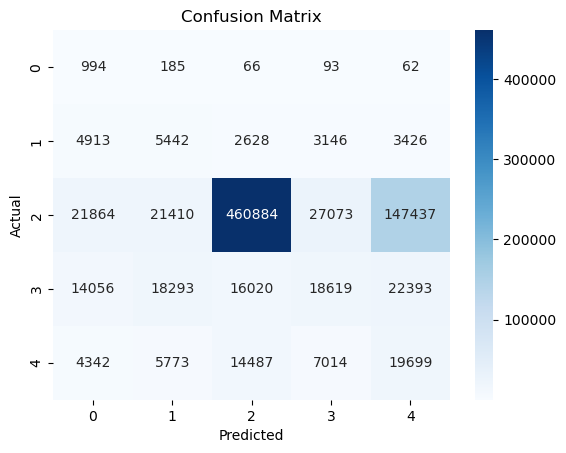

In [146]:
# create and display the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# create and display the classification report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.02      0.71      0.04      1400
           1       0.11      0.28      0.15     19555
           2       0.93      0.68      0.79    678668
           3       0.33      0.21      0.26     89381
           4       0.10      0.38      0.16     51315

    accuracy                           0.60    840319
   macro avg       0.30      0.45      0.28    840319
weighted avg       0.80      0.60      0.68    840319



### Cross-Validation

In [148]:
# cross validate the model
cross_val_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validated scores: {cross_val_scores}')

cross_val_scores

/Users/rob/micromamba/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rob/micromamba/envs/learn-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Cross-validated scores: [0.60147563 0.60665819 0.58917821 0.59912979 0.60437483]


array([0.60147563, 0.60665819, 0.58917821, 0.59912979, 0.60437483])

In [149]:
cross_val_scores

array([0.60147563, 0.60665819, 0.58917821, 0.59912979, 0.60437483])